In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [60]:
df = pd.read_csv('/kaggle/input/datasets/amitabhajoy/bengaluru-house-price-data/Bengaluru_House_Data.csv')
print(f"Dataset loaded! Shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))
print("\nColumn info:")
print(df.info())

Dataset loaded! Shape: (13320, 9)

First 3 rows:
              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    1332

In [61]:
cols = ['location', 'total_sqft', 'bath', 'balcony', 'size', 'price']
available_cols = [col for col in cols if col in df.columns]
df = df[available_cols].copy()

print(f"Selected: {df.columns.tolist()}")
print(f"Shape: {df.shape}")
print("\nFirst 3 rows:")
print(df.head(3))

Selected: ['location', 'total_sqft', 'bath', 'balcony', 'size', 'price']
Shape: (13320, 6)

First 3 rows:
                   location total_sqft  bath  balcony       size   price
0  Electronic City Phase II       1056   2.0      1.0      2 BHK   39.07
1          Chikka Tirupathi       2600   5.0      3.0  4 Bedroom  120.00
2               Uttarahalli       1440   2.0      3.0      3 BHK   62.00


In [62]:
print("Sample 'size' values:", df['size'].dropna().head().unique()[:10])

def extract_bhk(size):
    if pd.isna(size):
        return np.nan
    size = str(size).lower()
    if 'bhk' in size or 'bedroom' in size:
        try:
            return int(''.join(filter(str.isdigit, size)))
        except:
            return np.nan
    return np.nan

df['bhk'] = df['size'].apply(extract_bhk)

def clean_sqft(x):
    if isinstance(x, str):
        if '-' in x:
            try:
                low, high = map(float, x.split('-'))
                return (low + high) / 2
            except:
                return np.nan
        try:
            return float(x)
        except:
            return np.nan
    return float(x)

df['total_sqft'] = df['total_sqft'].apply(clean_sqft)

print("BHK extracted from 'size'!")
print("BHK samples:", df['bhk'].dropna().head().tolist())
print("total_sqft cleaned!")
print("sqft samples:", df['total_sqft'].dropna().head().tolist())


Sample 'size' values: ['2 BHK' '4 Bedroom' '3 BHK']
BHK extracted from 'size'!
BHK samples: [2.0, 4.0, 3.0, 3.0, 2.0]
total_sqft cleaned!
sqft samples: [1056.0, 2600.0, 1440.0, 1521.0, 1200.0]


In [63]:
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')
df['balcony'] = pd.to_numeric(df['balcony'], errors='coerce').fillna(0)

df['has_balcony'] = (df['balcony'] > 0).astype(int)

print("All numeric cleaning done!")
print("\nFeature preview:")
preview_cols = ['bhk', 'total_sqft', 'bath', 'has_balcony', 'price']
print(df[preview_cols].head())
print("\nStats:")
print(df[preview_cols].describe())

All numeric cleaning done!

Feature preview:
   bhk  total_sqft  bath  has_balcony   price
0  2.0      1056.0   2.0            1   39.07
1  4.0      2600.0   5.0            1  120.00
2  3.0      1440.0   2.0            1   62.00
3  3.0      1521.0   3.0            1   95.00
4  2.0      1200.0   2.0            1   51.00

Stats:
                bhk    total_sqft          bath   has_balcony         price
count  13291.000000  13274.000000  13247.000000  13320.000000  13320.000000
mean       2.805507   1559.626694      2.692610      0.877027    112.565627
std        1.294377   1238.405258      1.341458      0.328419    148.971674
min        1.000000      1.000000      1.000000      0.000000      8.000000
25%        2.000000   1100.000000      2.000000      1.000000     50.000000
50%        3.000000   1276.000000      2.000000      1.000000     72.000000
75%        3.000000   1680.000000      3.000000      1.000000    120.000000
max       43.000000  52272.000000     40.000000      1.000000  

In [64]:
print("Before cleaning:", df.shape)

df = df.dropna(subset=['bhk', 'total_sqft', 'bath', 'price'])
print(f"After dropna: {df.shape}")

df = df[
    (df['price'] < 200) &           # < 200 Cr
    (df['bhk'] < 20) &              # < 20 BHK
    (df['bath'] < 15) &             # < 15 baths
    (df['total_sqft'] > 300) &      # > 300 sqft
    (df['total_sqft'] < 30000)      # < 30k sqft
]

print(f"After outlier removal: {df.shape}")
print("\nFinal dataset stats:")
print(df[['bhk', 'total_sqft', 'bath', 'price']].describe())

Before cleaning: (13320, 8)
After dropna: (13188, 8)
After outlier removal: (11630, 8)

Final dataset stats:
                bhk    total_sqft          bath         price
count  11630.000000  11630.000000  11630.000000  11630.000000
mean       2.616681   1342.994091      2.471281     76.021664
std        1.047876    604.078835      1.047743     38.672731
min        1.000000    302.000000      1.000000      9.000000
25%        2.000000   1075.000000      2.000000     47.590000
50%        2.000000   1230.000000      2.000000     65.000000
75%        3.000000   1530.000000      3.000000     95.000000
max       11.000000  26136.000000     13.000000    199.000000


Current DataFrame columns & types:
location        object
total_sqft     float64
bath           float64
balcony        float64
size            object
price          float64
bhk            float64
has_balcony      int64
dtype: object

Numeric columns only for correlation:
Numeric columns: ['total_sqft', 'bath', 'balcony', 'price', 'bhk', 'has_balcony']


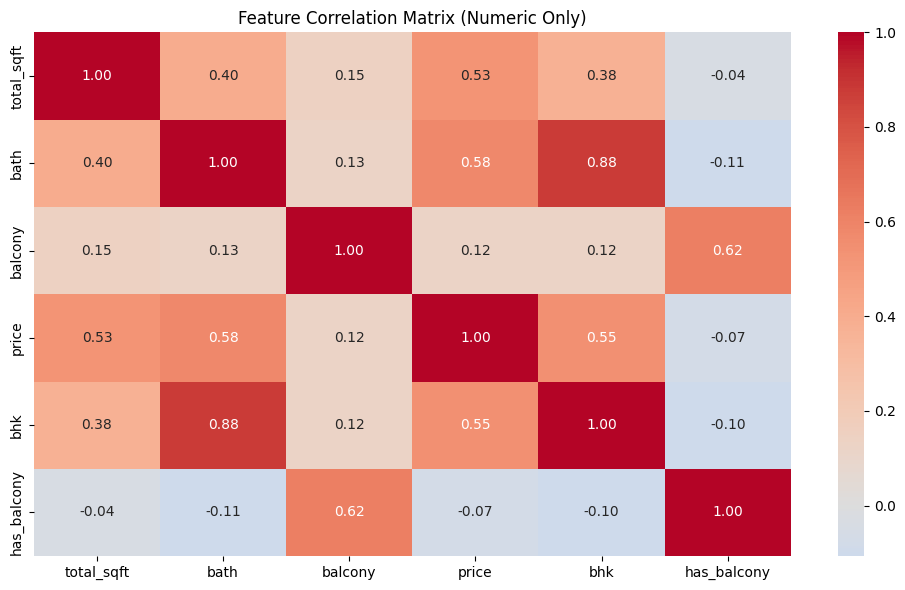


Strongest correlations with PRICE:
price          1.000
bath           0.581
bhk            0.546
total_sqft     0.529
balcony        0.125
has_balcony   -0.069
Name: price, dtype: float64


In [65]:
print("Current DataFrame columns & types:")
print(df.dtypes)
print("\nNumeric columns only for correlation:")

numeric_cols = df.select_dtypes(include=[np.number]).columns
print("Numeric columns:", numeric_cols.tolist())

corr = df[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix (Numeric Only)')
plt.tight_layout()
plt.show()

print("\nStrongest correlations with PRICE:")
price_corr = corr['price'].sort_values(ascending=False)
print(price_corr.round(3))

Creating regression relationship visualizations...


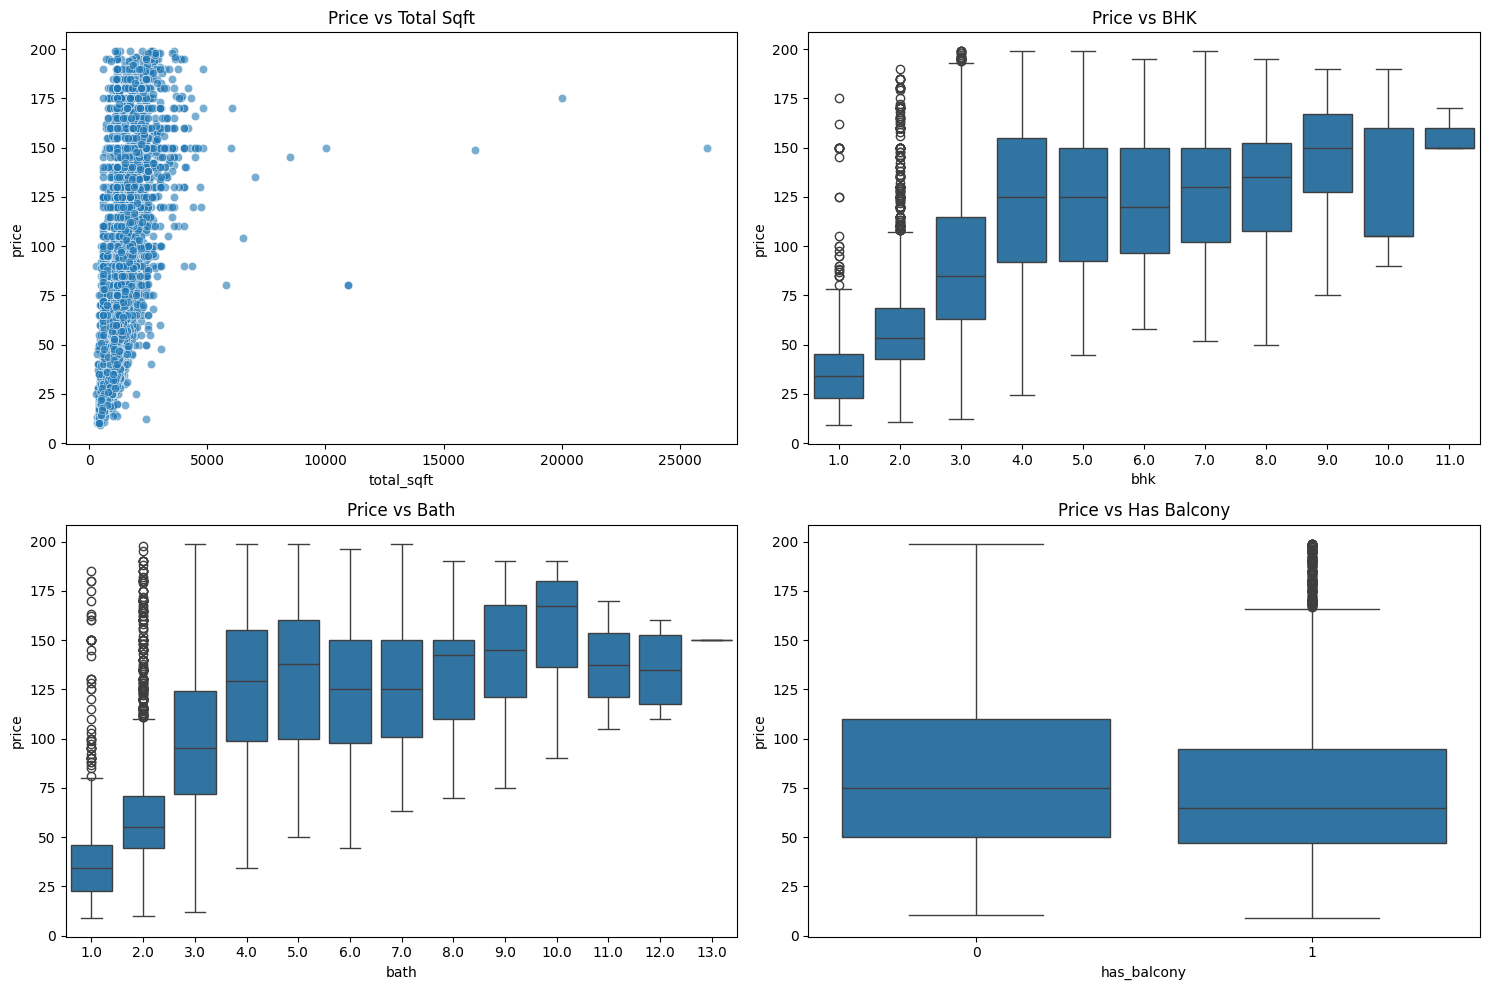

All 4 regression plots created successfully!


In [66]:
print("Creating regression relationship visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(x='total_sqft', y='price', data=df, ax=axes[0,0], alpha=0.6)
axes[0,0].set_title('Price vs Total Sqft')

sns.boxplot(x='bhk', y='price', data=df, ax=axes[0,1])
axes[0,1].set_title('Price vs BHK')

sns.boxplot(x='bath', y='price', data=df, ax=axes[1,0])
axes[1,0].set_title('Price vs Bath')

sns.boxplot(x='has_balcony', y='price', data=df, ax=axes[1,1])
axes[1,1].set_title('Price vs Has Balcony')

plt.tight_layout()
plt.show()

print("All 4 regression plots created successfully!")

In [67]:
X = df[['location', 'total_sqft', 'bhk', 'bath', 'has_balcony']]
y = df['price']

print("Training features prepared!")
print(f"X shape: {X.shape}, y shape: {y.shape}")
print("\nFeature columns:", X.columns.tolist())
print("\nTarget price range: ₹{:.1f}Lakh - ₹{:.1f}Lakh".format(y.min(), y.max()))

Training features prepared!
X shape: (11630, 5), y shape: (11630,)

Feature columns: ['location', 'total_sqft', 'bhk', 'bath', 'has_balcony']

Target price range: ₹9.0Lakh - ₹199.0Lakh


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Data split completed!")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Data split completed!
Train: (9304, 5), Test: (2326, 5)


In [69]:
print("Encoding locations Safely...")

top_locations = X_train['location'].value_counts().head(100).index

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

X_train_enc['location'] = X_train_enc['location'].apply(lambda x: x if x in top_locations else 'other')
X_test_enc['location'] = X_test_enc['location'].apply(lambda x: x if x in top_locations else 'other')

print(f"Reduced locations: {X_train['location'].nunique()} → {X_train_enc['location'].nunique()}")

le = LabelEncoder()
X_train_enc['location'] = le.fit_transform(X_train_enc['location'])
X_test_enc['location'] = le.transform(X_test_enc['location']) 

print("Encoding successful!")
print(f"Train locations range: 0-{X_train_enc['location'].max()}")
print(f"Test locations range: {X_test_enc['location'].min()}-{X_test_enc['location'].max()}")

num_features = ['location', 'total_sqft', 'bhk', 'bath', 'has_balcony']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc[num_features])
X_test_scaled = scaler.transform(X_test_enc[num_features])

print("Scaling completed!")
print(f"Final shapes: {X_train_scaled.shape}, {X_test_scaled.shape}")
print("\nCell 11 FIXED! Ready for model training!")


Encoding locations Safely...
Reduced locations: 1089 → 101
Encoding successful!
Train locations range: 0-100
Test locations range: 0-100
Scaling completed!
Final shapes: (9304, 5), (2326, 5)

Cell 11 FIXED! Ready for model training!


In [70]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Model trained successfully!")
print(f"Coefficients shape: {model.coef_.shape}")

Model trained successfully!
Coefficients shape: (5,)


In [71]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("Predictions generated!")
print(f"Train predictions: {y_pred_train[:5]}")
print(f"Test predictions: {y_pred_test[:5]}")

Predictions generated!
Train predictions: [67.61891007 92.50504137 76.54029382 53.49456906 65.85877502]
Test predictions: [74.86676038 66.53658906 89.77301449 67.12254916 85.85447545]


In [72]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("PERFORMANCE METRICS")
print("="*40)
print(f"TRAIN - RMSE: {train_rmse:.2f} | R²: {train_r2:.4f}")
print(f"TEST  - RMSE: {test_rmse:.2f} | R²: {test_r2:.4f}")
print("\nMetrics calculated!")

PERFORMANCE METRICS
TRAIN - RMSE: 29.02 | R²: 0.4432
TEST  - RMSE: 27.63 | R²: 0.4625

Metrics calculated!


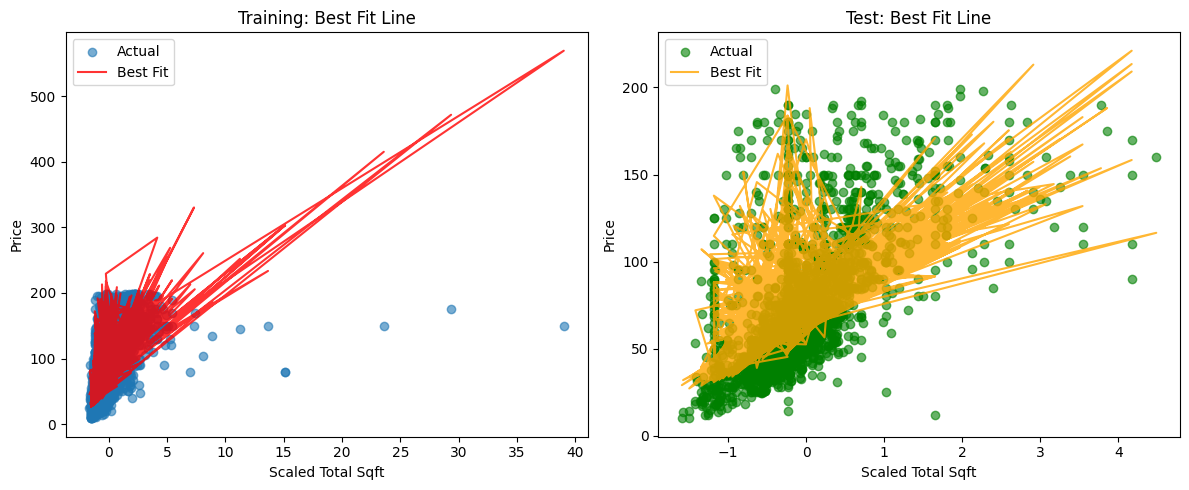

Best fit line visualized!


In [73]:
total_sqft_train = X_train_scaled[:, 1]
total_sqft_test = X_test_scaled[:, 1]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(total_sqft_train, y_train, alpha=0.6, label='Actual')
plt.plot(total_sqft_train, y_pred_train, color='red', alpha=0.8, label='Best Fit')
plt.xlabel('Scaled Total Sqft')
plt.ylabel('Price')
plt.title('Training: Best Fit Line')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(total_sqft_test, y_test, alpha=0.6, color='green', label='Actual')
plt.plot(total_sqft_test, y_pred_test, color='orange', alpha=0.8, label='Best Fit')
plt.xlabel('Scaled Total Sqft')
plt.ylabel('Price')
plt.title('Test: Best Fit Line')
plt.legend()

plt.tight_layout()
plt.show()

print("Best fit line visualized!")

Analyzing residuals for model validation...


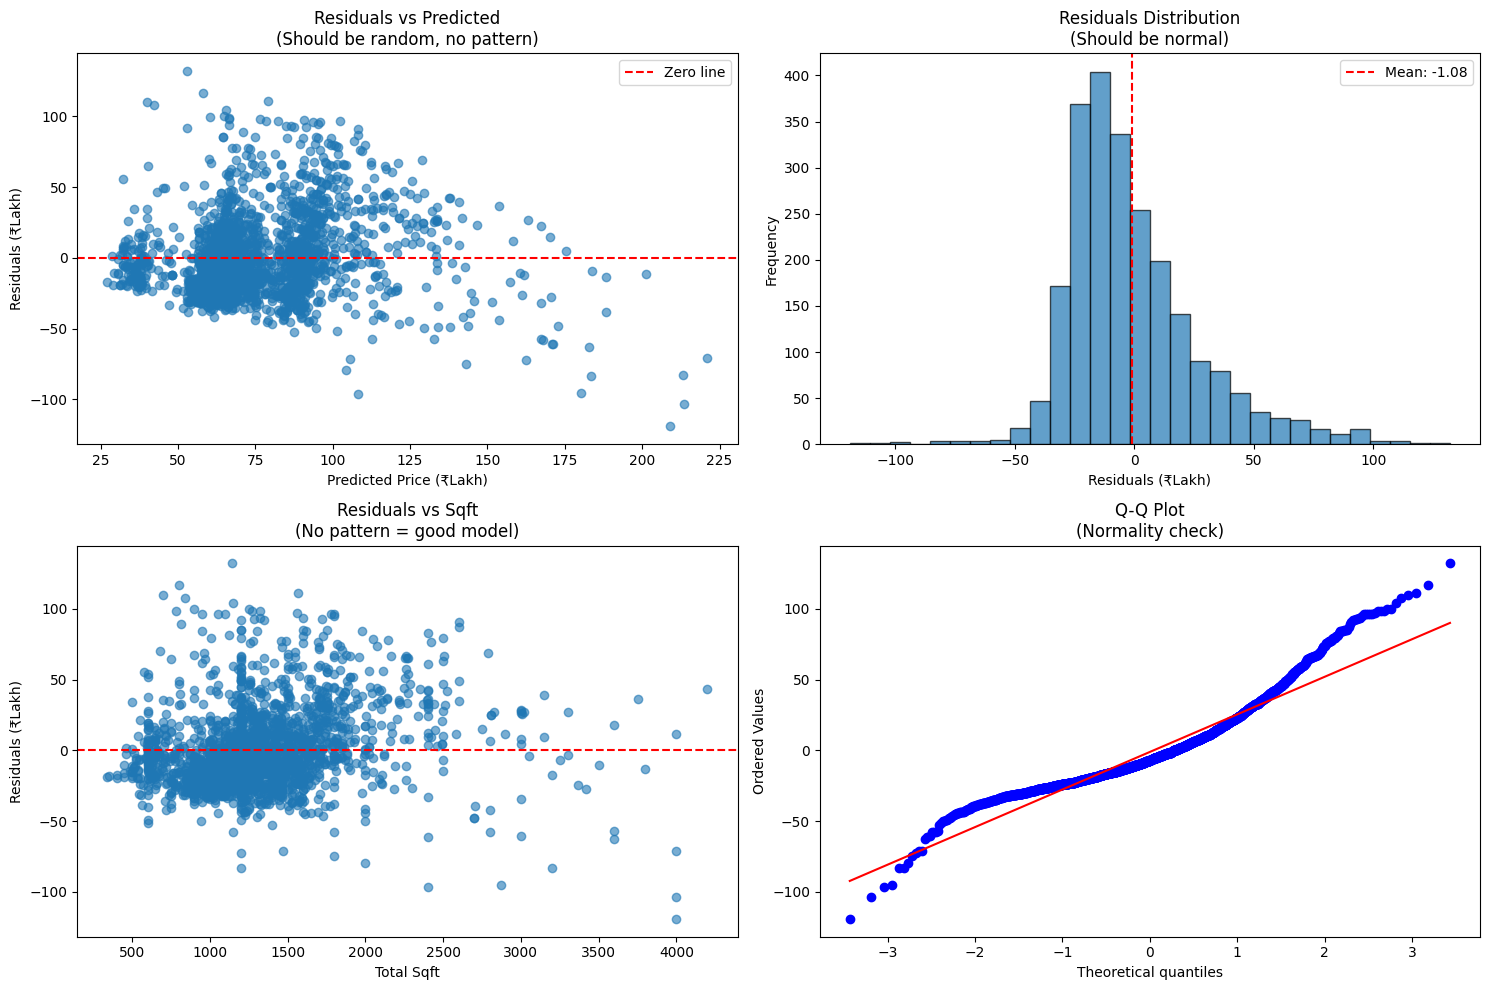

Residual Analysis COMPLETE!
Residuals Mean: -1.0815 (should be ~0)
Residuals Std:  27.6167
RMSE:           27.63 Lakh

INTERPRETATION:
-Mean ~0: Model unbiased
-Random scatter: Linear assumptions valid
-Normal histogram: Homoscedasticity OK
-Q-Q straight: Residuals normal


In [74]:
residuals_test = y_test - y_pred_test

print("Analyzing residuals for model validation...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].scatter(y_pred_test, residuals_test, alpha=0.6)
axes[0,0].axhline(y=0, color='red', linestyle='--', label='Zero line')
axes[0,0].set_xlabel('Predicted Price (₹Lakh)')
axes[0,0].set_ylabel('Residuals (₹Lakh)')
axes[0,0].set_title('Residuals vs Predicted\n(Should be random, no pattern)')
axes[0,0].legend()

axes[0,1].hist(residuals_test, bins=30, edgecolor='black', alpha=0.7)
axes[0,1].axvline(residuals_test.mean(), color='red', linestyle='--', 
                  label=f'Mean: {residuals_test.mean():.2f}')
axes[0,1].set_xlabel('Residuals (₹Lakh)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Residuals Distribution\n(Should be normal)')
axes[0,1].legend()

total_sqft_test = X_test['total_sqft'].values 
axes[1,0].scatter(total_sqft_test, residuals_test, alpha=0.6)
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Total Sqft')
axes[1,0].set_ylabel('Residuals (₹Lakh)')
axes[1,0].set_title('Residuals vs Sqft\n(No pattern = good model)')

from scipy import stats
stats.probplot(residuals_test, dist="norm", plot=axes[1,1])
axes[1,1].set_title('Q-Q Plot\n(Normality check)')

plt.tight_layout()
plt.show()

print("Residual Analysis COMPLETE!")
print(f"Residuals Mean: {residuals_test.mean():.4f} (should be ~0)")
print(f"Residuals Std:  {residuals_test.std():.4f}")
print(f"RMSE:           {np.sqrt((residuals_test**2).mean()):.2f} Lakh")
print("\nINTERPRETATION:")
print("-Mean ~0: Model unbiased")
print("-Random scatter: Linear assumptions valid") 
print("-Normal histogram: Homoscedasticity OK")
print("-Q-Q straight: Residuals normal")


In [75]:
def predict_house_price(location, total_sqft, bhk, bath, balcony=0):
    input_df = pd.DataFrame({
        'location': [location],
        'total_sqft': [total_sqft],
        'bhk': [bhk],
        'bath': [bath],          
        'has_balcony': [1 if balcony > 0 else 0]
    })

    input_df['location'] = input_df['location'].apply(
        lambda x: x if x in top_locations else 'other'
    )
    
    input_df['location'] = le.transform(input_df['location'])
    
    features = ['location', 'total_sqft', 'bhk', 'bath', 'has_balcony']
    input_scaled = scaler.transform(input_df[features])
    
    price = model.predict(input_scaled)[0]
    return price

print("SAMPLE HOUSE PRICE PREDICTIONS:")
print("="*50)

p1 = predict_house_price('Whitefield', 1500, 3, 2, 1)
print(f"3BHK | 1500sqft | Whitefield | 2bath | Balcony → ₹{p1:.2f} Lakh")

p2 = predict_house_price('Electronic City Phase II', 1000, 2, 2, 0)
print(f"2BHK | 1000sqft | Electronic City | 2bath → ₹{p2:.2f} Lakh")

p3 = predict_house_price('Koramangala', 3000, 4, 4, 2)
print(f"4BHK | 3000sqft | Koramangala | 4bath | Balcony → ₹{p3:.2f} Lakh")

print("\nPrediction function working properly!")

SAMPLE HOUSE PRICE PREDICTIONS:
3BHK | 1500sqft | Whitefield | 2bath | Balcony → ₹76.84 Lakh
2BHK | 1000sqft | Electronic City | 2bath → ₹58.08 Lakh
4BHK | 3000sqft | Koramangala | 4bath | Balcony → ₹134.85 Lakh

Prediction function working properly!


In [77]:
import pickle
pickle.dump({
    'model': model, 'scaler': scaler, 'le': le, 'top_locations': top_locations
}, open('house_model.pkl', 'wb'))
print("Model exported! Download 'house_model.pkl'")

Model exported! Download 'house_model.pkl'
